In [1]:
import tensorflow as tf
import pathlib

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [3]:
data_root_orig = '../input/train_images'


In [4]:
data_root_orig

'../input/train_images'

In [5]:
data_root = pathlib.Path(data_root_orig)

In [6]:
data_root

PosixPath('../input/train_images')

In [9]:
import random
all_image_paths = list(data_root.glob('./*'))

In [12]:
import pandas as pd

train_labels = pd.read_csv("../input/train_images.csv")


In [13]:
train_labels.head()

,id,class_num
0,train_0000.jpg,0
1,train_0001.jpg,0
2,train_0002.jpg,0
3,train_0003.jpg,0
4,train_0004.jpg,0


In [14]:
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)


In [16]:
image_count

1102

In [17]:
train_labels.describe()

,class_num
count,1102.000000
mean,1.235027
std,1.136516
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,3.000000


In [19]:
import IPython.display as display
import random

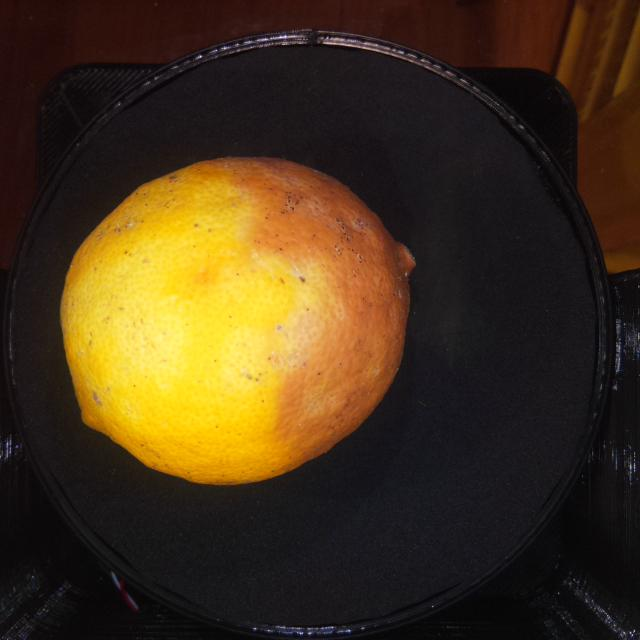

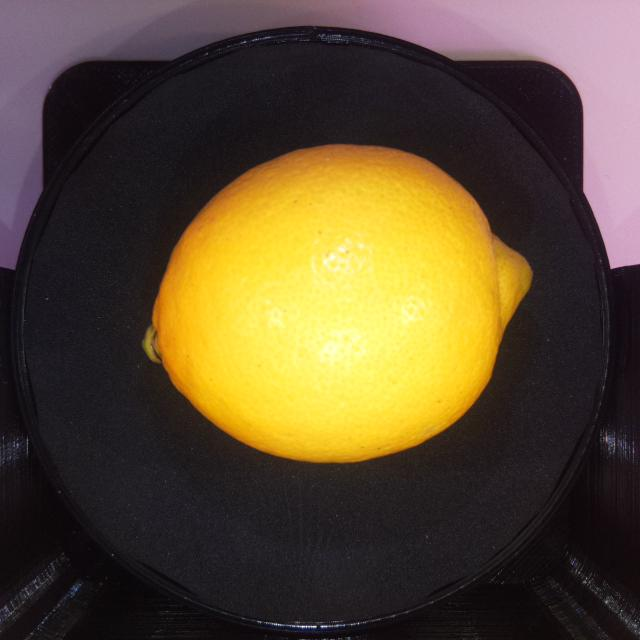

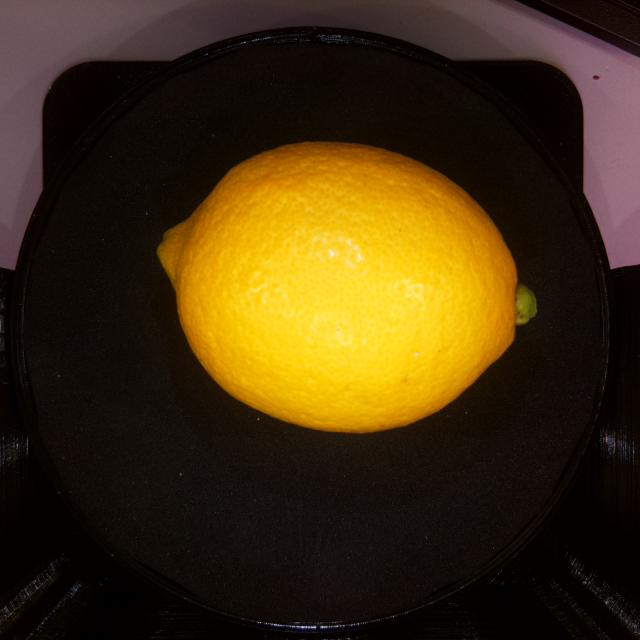

In [20]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))

In [21]:
all_image_paths.sort()

In [24]:
img_path = all_image_paths[0]

In [27]:
img_path

'../input/train_images/train_0000.jpg'

In [25]:
img_raw = tf.io.read_file(img_path)

In [28]:
img_tensor = tf.image.decode_image(img_raw)

In [29]:
img_tensor.shape

TensorShape([640, 640, 3])

In [30]:
img_tensor.dtype

tf.uint8

In [31]:
img_final = tf.image.resize(img_tensor, [192,192])
img_final = img_final/255.0

In [32]:
img_final.shape

TensorShape([192, 192, 3])

In [34]:
img_final.numpy().min()

0.0

In [35]:
img_final.numpy().max()

1.0